# Predicting Rain in Australia

<div id='back'></div>

In this notebook, I will be using the 'Rain in Australia' dataset to predict if it will rain in Australia tomorrow. Here is the link to the dataset: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

The target variable is binary (will it rain or not tomorrow in Australia), and I will train a Logistic Regression model on the dataset to predict the outcome. 

Here is a summary of my workflow:


1.  [DATA PREPARATION](#DataPrep)  
   **a)** [Preliminary work](#pw) on the dataset - extract columns into list of features, drop 'Risk_MM' and 'RainTomorrow from list, and binarise target column.  
   **b)** [Selecting features](#sf) -  missing values, pairwise correlation, feature engineering (new features, one-hot encoding, cyclical features)    
   
2. [MODEL TRAINING](#mt)  
   **c)** [Split dataset into train and test sets](#split)       
   **d)** [Scale features](#scale)      
   **e)** [Train Logistic Regression model](#train)     
   **f)** [Evaluate](#eval)    

In [3]:
import numpy as np 
import pandas as pd 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
#reading in csv file and changing dtype of 'Date' column to datetime
weather = pd.read_csv('weatherAUS.csv')

## **About the Rain in Australia dataset**

In [6]:
#dataset info
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
Date             142193 non-null object
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null obje

In [7]:
#timespan of data
print("The weather data was collected over the time period {0} to {1}.".format(weather.loc[0, 'Date'], weather.loc[142192, 'Date']))

The weather data was collected over the time period 2008-12-01 to 2017-06-24.


There are 142193 entries, and 24 variables. The columns of the *weather* dataset are:

**Date** - The date of observation  
**Location** - The common name of the location of the weather station  
**MinTemp** - The minimum temperature in degrees celsius  
**MaxTemp** - The maximum temperature in degrees celsius    
**Rainfall** - The amount of rainfall recorded for the day in mm  
**Evaporation** - The so-called Class A pan evaporation (mm) in the 24 hours to 9am (Class A pan evaporation is measured as the depth of water which evaporates from a pan of a certain size in 24 hours)  
**Sunshine** - The number of hours of bright sunshine in the day  
**WindGustDir** - The direction of the strongest wind gust in the 24 hours to midnight  
**WindGustSpeed** - The speed (km/h) of the strongest wind gust in the 24 hours to midnight  
**WindDir9am** - Direction of the wind at 9am  
**WindDir3pm** - Direction of the wind at 3pm  
**WindSpeed9am** - Wind speed (km/hr) averaged over 10 minutes prior to 9am  
**WindSpeed3pm** - Wind speed (km/hr) averaged over 10 minutes prior to 3pm  
**Humidity9am** - Humidity (percent) at 9am  
**Humidity3pm** - Humidity (percent) at 3pm  
**Pressure9am** - Atmospheric pressure (hpa) reduced to mean sea level at 9am  
**Pressure3pm** - Atmospheric pressure (hpa) reduced to mean sea level at 3pm  
**Cloud9am** - Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast    
**Cloud3pm** - Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values  
**Temp9am** - Temperature (degrees C) at 9am  
**Temp3pm** - Temperature (degrees C) at 3pm  
**RainToday** -  Yes if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise No  
**RISK_MM** - The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk"  
**RainTomorrow** - The target variable. Did it rain tomorrow, Yes or No?

In [8]:
#number of missing values in each variable
weather.isnull().sum().sort_values(ascending=False)

Sunshine         67816
Evaporation      60843
Cloud3pm         57094
Cloud9am         53657
Pressure9am      14014
Pressure3pm      13981
WindDir9am       10013
WindGustDir       9330
WindGustSpeed     9270
WindDir3pm        3778
Humidity3pm       3610
Temp3pm           2726
WindSpeed3pm      2630
Humidity9am       1774
RainToday         1406
Rainfall          1406
WindSpeed9am      1348
Temp9am            904
MinTemp            637
MaxTemp            322
Location             0
RainTomorrow         0
RISK_MM              0
Date                 0
dtype: int64

Theare is a sizeable amount of missing values to handle. The variables 'Sunshine' and 'Evaporation' have roughly half of their values missing. The target variable, 'Rain Tomorrow',  has no missing values.

<div id="DataPrep"></div><font size = 5>**1. Data Preparation **</font>

### a)<div id ='pw'>Preliminary work</div>

First, we will extract all the columns of the dataset into a list. As we go and prepare the data and pick the features,we will drop the columns we do not need. In this way, if we need to change features or check something, we can easily go back to the orginal dataset. We can index into the dataset with the final list of columns when we are ready to train and test the model.

We will drop rows in place in the original dataset.

In [9]:
#list of columns
features = weather.columns.tolist()
#check
features

['Date',
 'Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RISK_MM',
 'RainTomorrow']

Next, we will drop 'RainTomorrow' from our list of features as this is our target variable.

In [10]:
#drop target variable from list of features
features.remove('RainTomorrow')

Drop the column 'RISK_MM' from the weather dataset as it leaks information about the future. Please see [here](http://www.kaggle.com/jsphyg/weather-dataset-rattle-package/discussion/78316) for an explanation.

In [11]:
#drop RISK_MM from list of features
features.remove('RISK_MM')

 Binarise the column 'Rain Today' and the target column, 'Rain Tomorrow'.

In [12]:
#how many missing values in 'RainToday'
print('There are {} missing values in "Rain Today", and they make up {:.2f}% of the number of entries.'
      .format(weather['RainToday'].isnull().sum(),(weather['RainToday'].isnull().sum())/(weather.shape[0])*100))

There are 1406 missing values in "Rain Today", and they make up 0.99% of the number of entries.


We will drop the rows with missing values in 'RainToday' as they make up just about 1% of the total number of entries, and I cannot think of a way to impute for the missing values of this particular variable.

In [13]:
#drop rows with missing values in 'RainToday'
weather = weather[weather['RainToday'].notnull()]
#check
weather['RainToday'].unique()

array(['No', 'Yes'], dtype=object)

In [14]:
#any missing values in the target variable?
weather['RainTomorrow'].isnull().sum()

0

In [15]:
#for checking purposes
RToday_values_before = weather['RainToday'].value_counts()
RTomorrow_values_before = weather['RainTomorrow'].value_counts()
print('Value count in "Rain Today":\n {}'.format(RToday_values_before))
print('Value count in "Rain Tomorrow":\n {}'.format(RTomorrow_values_before))

Value count in "Rain Today":
 No     109332
Yes     31455
Name: RainToday, dtype: int64
Value count in "Rain Tomorrow":
 No     109586
Yes     31201
Name: RainTomorrow, dtype: int64


In [16]:
#binarise 'RainToday' and 'RainTomorrow'
weather['RainToday'] = (weather['RainToday'] == 'Yes')*1
weather['RainTomorrow'] = (weather['RainTomorrow'] == 'Yes')*1

In [17]:
#check
print('Value count in "Rain Today":\n {}'.format(weather['RainToday'].value_counts()))
print('\nValue count in "Rain Tomorrow":\n {}'.format(weather['RainTomorrow'].value_counts()))

Value count in "Rain Today":
 0    109332
1     31455
Name: RainToday, dtype: int64

Value count in "Rain Tomorrow":
 0    109586
1     31201
Name: RainTomorrow, dtype: int64


We have now binarised the 'RainToday' and the target variable 'RainTomorrow' so that 1 indicates rain and 0 indicates no rain.

[Back to contents](#back)

### b)<div id='sf'></div>** Feature Selection**

Let's see how many entries we are left with if we drop all the missing values in this dataset. 


In [18]:
before_rows = weather.shape[0]
copy_data = weather.copy()
mod_data = copy_data.dropna()
after_rows = mod_data.shape[0]
print('{} rows are dropped.'.format(before_rows - after_rows))
print('\nDropping rows with at least one missing value will reduce our dataset by {:.2f} %.'.format((before_rows - after_rows)/before_rows*100))

84367 rows are dropped.

Dropping rows with at least one missing value will reduce our dataset by 59.93 %.


Instead of dropping all the rows with a missing value (and risk losing valuable information), we will examine each of the columns individually, and their relationship to each other. 

In [19]:
weather[features].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
count,140319.000000,140480.00000,140787.000000,81093.000000,73982.000000,131682.000000,139732.000000,138256.000000,139270.000000,137286.000000,127044.000000,127018.000000,88162.000000,84693.000000,140131.000000,138163.000000,140787.000000
mean,12.184824,23.23512,2.349974,5.472516,7.630540,39.970520,13.990496,18.631141,68.826833,51.449288,1017.654577,1015.257963,4.431161,4.499250,16.987066,21.693183,0.223423
std,6.403879,7.11450,8.465173,4.189132,3.781729,13.578201,8.886210,8.798096,19.063650,20.807310,7.104867,7.035411,2.886594,2.719752,6.496012,6.937784,0.416541
min,-8.500000,-4.80000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.90000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.60000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.30000,0.800000,7.400000,10.700000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.000000
max,33.900000,48.10000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,1.000000


Are any of the features with contiunous data type strongly correlated (linearly) with one another?

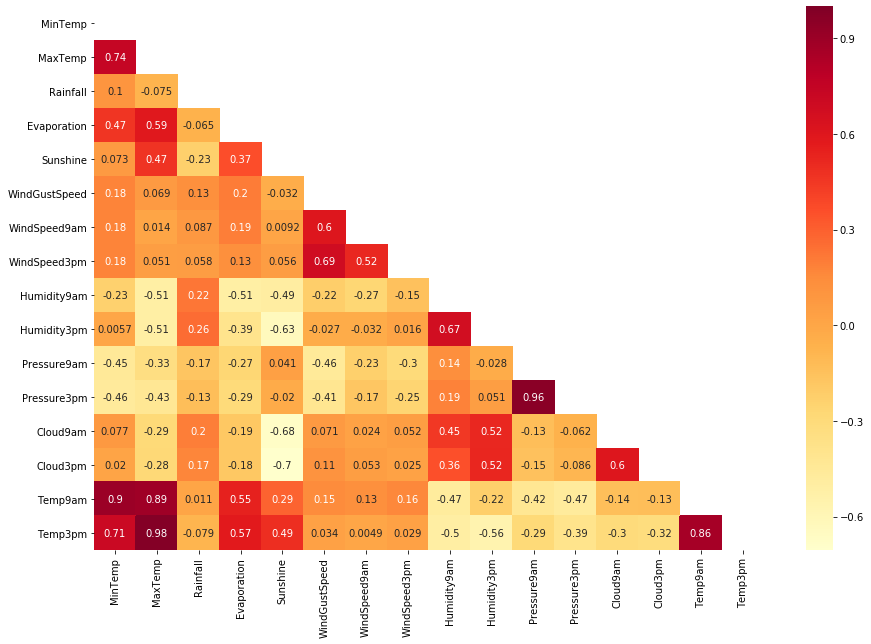

In [20]:
plt.figure(figsize=(15,10))
cont_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation','Sunshine',
                 'WindGustSpeed','WindSpeed9am','WindSpeed3pm', 'Humidity9am',
                'Humidity3pm', 'Pressure9am', 'Pressure3pm','Cloud9am', 'Cloud3pm',
                'Temp9am','Temp3pm']
corr_weather = weather[cont_features].corr()
mask = np.triu(np.ones_like(corr_weather, dtype=bool))
sns.heatmap(corr_weather, mask=mask,annot=True, cmap='YlOrRd')
#heatmap cuts off top and bottom so following code is a fix
bottom, top = plt.ylim() 
bottom += 0.5 
top -= 0.5 
plt.ylim(bottom, top)
plt.show()

From the correlation matrix, we can see that there is very strong correlation (corr $\geq$ 80) between:
* 'Temp3pm' and 'MaxTemp' (corr = 0.98) (near perfect correlation)
* 'Pressure9am' and 'Pressure3pm' (corr = 0.96) (near perfect correlation)
* 'Temp9am' and 'MinTemp' (corr = 0.9)
* 'Temp9am' and 'MaxTemp' (corr = 0.89)
* 'Temp9am and 'Temp3pm' (corr = 0.86)

There is moderate to strong correlation (0.65 $\leq$ corr $<$ 0.8) between:
* 'MaxTemp' and 'MinTemp' (corr = 0.74)
* 'WindSpeed3pm' and 'WindGustSpeed' (corr = 0.69)
* 'Cloud9am' and 'Sunshine' (corr = -0.68)
* 'Cloud3pm' and 'Sunshine' (corr = -0.7)
* 'Humidity9am' and 'Humidity3pm' (corr =  0.67)

In order to avoid problesm in the model from high collinearity between variables, we will drop the feature in the above pairs which has the weakest relationship with the target variable. SInce 'RainTomorrow' is binary, we will create scatter plots to see what kind of relationship, if any, exists.

In the examining the following scatterplots, it is important to keep in mind that 'RainTomorrow' indicates no rain 3.5 times more than it indicates rain.

In [21]:
#'RainTomorrow' value counts
weather['RainTomorrow'].value_counts()

0    109586
1     31201
Name: RainTomorrow, dtype: int64

First, we will consider the temperature variables.

<Figure size 1080x1080 with 0 Axes>

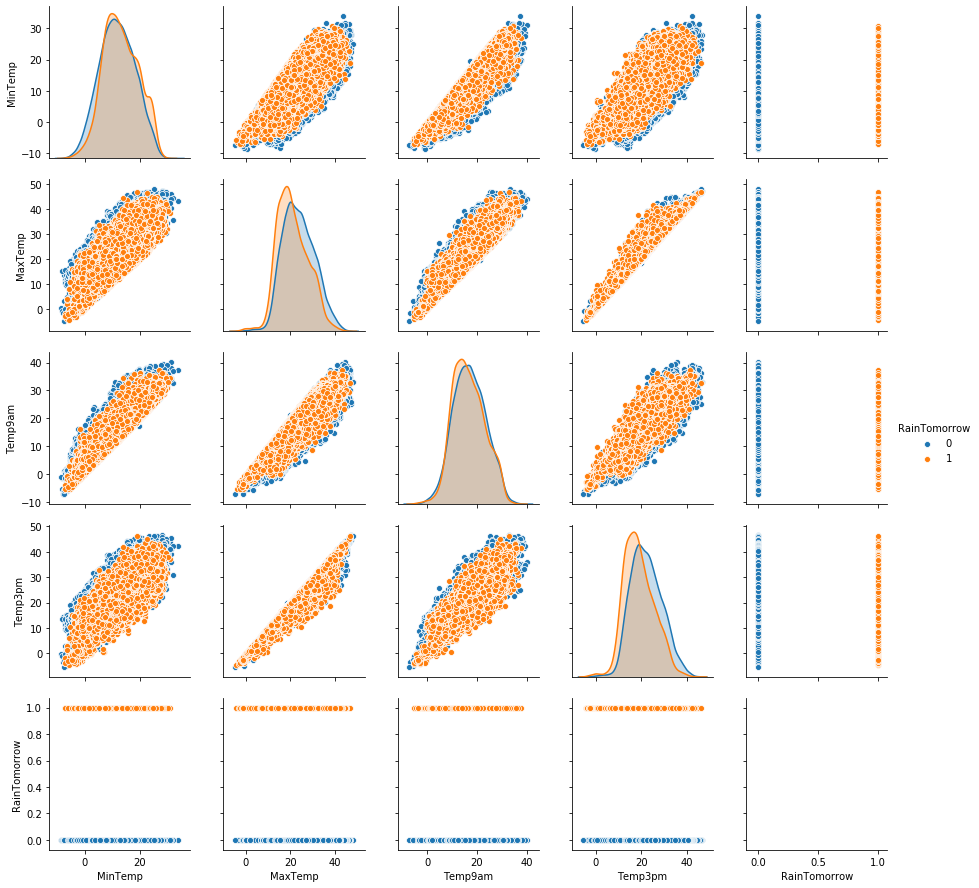

In [22]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#pairwise scatter plots of temperature variables
plt.figure(figsize=(15,15))
sns.pairplot(weather[['MinTemp','MaxTemp','Temp9am','Temp3pm','RainTomorrow']], hue = 'RainTomorrow' )
plt.show()

We know from the correlation matrix that there are strong positive relationships between the temperature variables. 

There is not much of a difference in the shape and position of the 'RainTomorrow' distributions for 'MinTemp' and 'Temp9am'. For 'MaxTemp' and 'Temp3pm',  'RainTomorrow' is 'Yes' more often at lower temperatures, and 'Temp3pm' shows a greater difference between the 'Yes' and 'No' distributions of 'RainTomorrow' than 'MaxTemp'. 

Based on this, we will drop 'Temp9am', 'MaxTemp', and 'MinTemp' from our list of features for the model, and keep 'Temp3pm'.

'Sunshine', 'Cloud9am', 'Cloud3pm', and 'Evaporation' are grouped together next as it is obvious from a practical point of view that they may have a relationship. In a basic sense, we know that if it is very cloudy, there will be little sunshine. 

<Figure size 1080x1080 with 0 Axes>

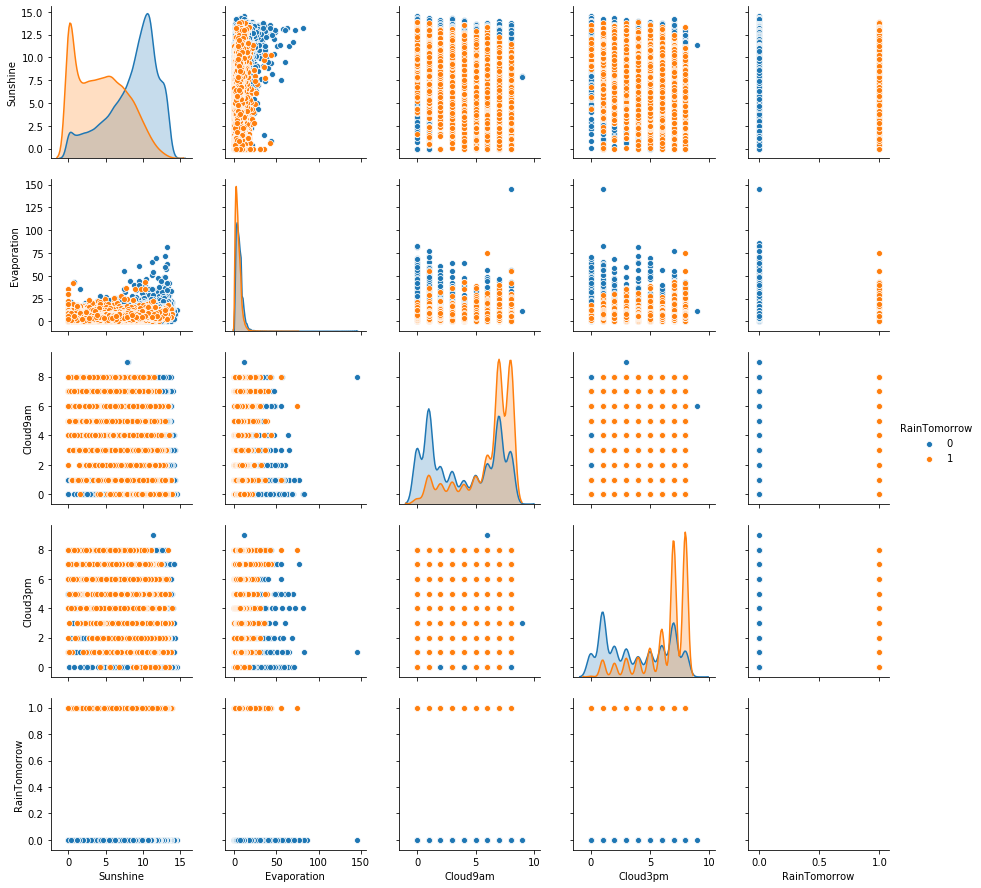

In [23]:
#pairwise scatter plots of 'Sunshine','Cloud9am,'Cloud3pm', and 'Evaporation'
plt.figure(figsize=(15,15))
sns.pairplot(weather[['Sunshine','Evaporation','Cloud9am','Cloud3pm','RainTomorrow']], hue = 'RainTomorrow' )
plt.show()

The correlation matrix indicated a moderately strong negative relationship between 'Sunshine' and both 'Cloud9am' and'Cloud3pm'. The pairwise plots do not seem to indicate that relationship. 

On the first diagonal plot, we can see that the distribution of 'Yes' values for 'RainTomorrow' skews left (lower values for 'Sunshine') and the distribution of 'No' values for 'RainTomorrow' skews right (higher values for 'Sunshine'. From this, the number of hours of 'Sunshine' is a good determinant of 'RainTomorrow'.

On the second diagonal plot, there in't much of a difference between the distributions of the binary values of 'RainTomorrow' on 'Evaporation'.

On the third and fourth diagonal plts, the distribution of 'Yes' values for 'RainTomorrow' skews right and the distribution of 'No' values for 'RainTomorrow' skews left. This indicates that 'Cloud9am' and 'Cloud3pm' are  good determinants of 'RainTomorrow'.

Based on these observations, we will drop 'Evaporation', and deal with 'Sunshine', Cloud9am', and 'Cloud3pm' later.



<Figure size 1080x1080 with 0 Axes>

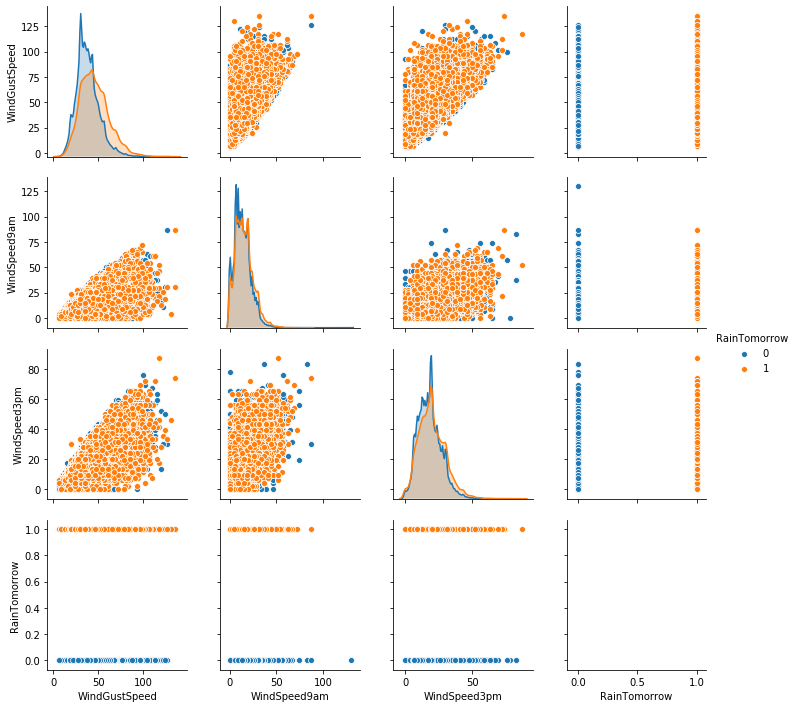

In [24]:
#pairwise scatter plots of wind variables
plt.figure(figsize=(15,15))
sns.pairplot(weather[['WindGustSpeed','WindSpeed9am','WindSpeed3pm','RainTomorrow']], hue = 'RainTomorrow' )
plt.show()

We know from the correlation matrix that 'WindGustSpeed'has a strong positive correlation with 'WindSpeed3pm' and a moderate positive relationshipe with 'Windspeed9am'. This is reflected in the scatter plots.

The plots on the diagonal show that the distribution of the 'Yes' and 'No' values of 'RainTomorrow' are similar for 'WindSpeed9am' and 'WindSpeed3pm'. For, 'WindGustSpeed', the 'No' values skew to the left and the 'Yes' values to the right which indicates that a higher wind gust speed may indicate rain the next day. 

Based on these observations, we will drop 'WindSpeed9am' and 'WindSpeed3pm' from our model.

<Figure size 1080x1080 with 0 Axes>

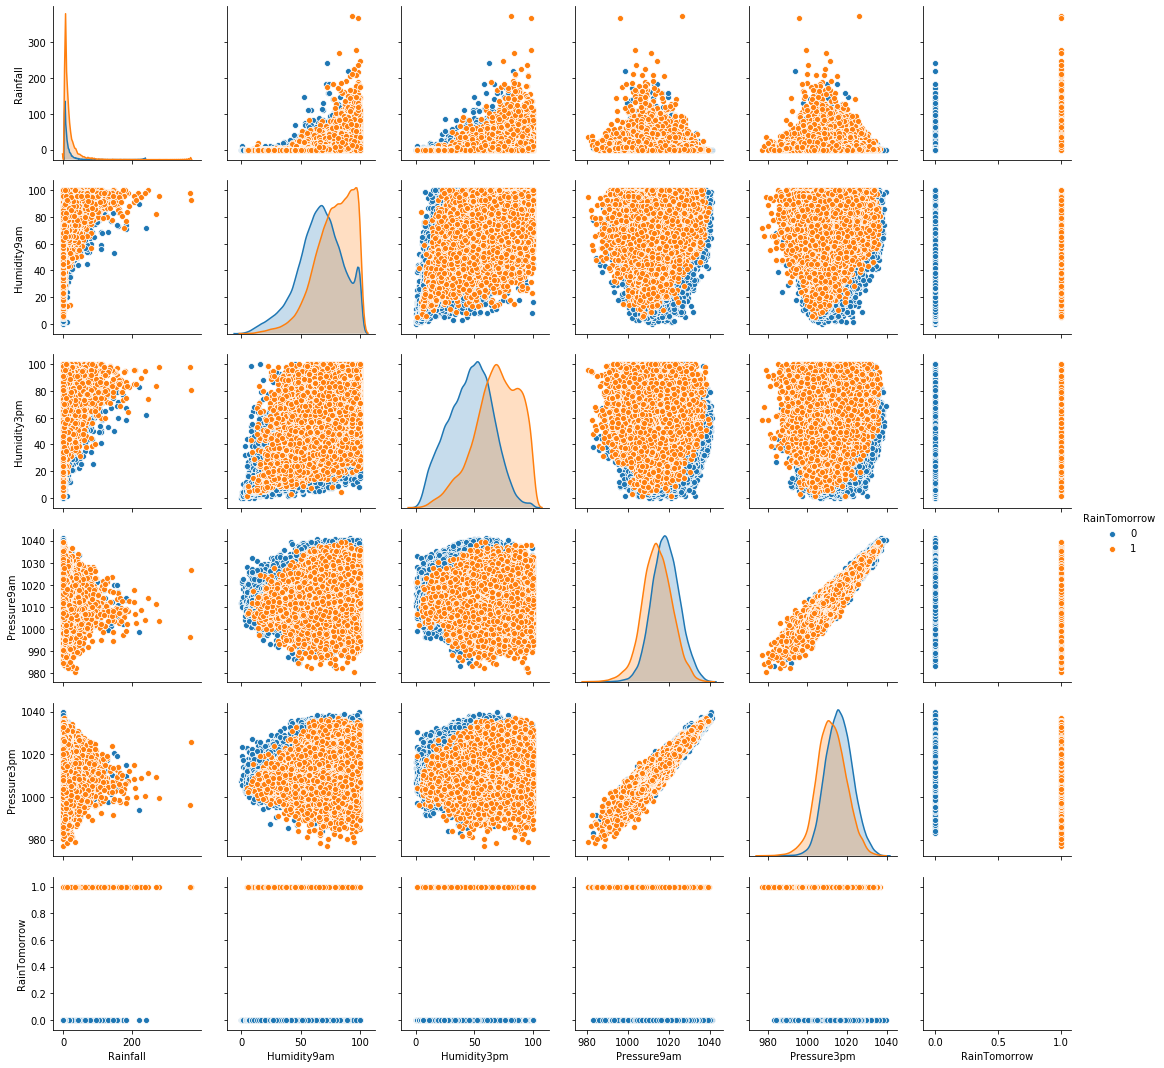

In [25]:
#pairwise scatter plots of rainfall, pressure and humidity variables
plt.figure(figsize=(15,15))
sns.pairplot(weather[['Rainfall','Humidity9am','Humidity3pm','Pressure9am', 'Pressure3pm','RainTomorrow']], hue = 'RainTomorrow' )
plt.show()

The near perfect positive linear relationship between 'Pressure9am' and 'Pressure3pm' is reflected in this scatter point. There is no obvious difference in the distributions in the 'Yes' and 'No' values of 'RainTomorrow' with regards to both the pressure variables. 

The 'Yes' values of 'RainTomorrow' skew to the left of the 'No' values for both 'Humidity9am' and 'Humidity3pm', and to a greater degree for 'Humidity3pm'.


Based on these observations, we will drop 'Humidity9am' and 'Pressure9am' from the model.


'RainToday' is described  as 'Yes' if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise No. 'Rainfall' is described as the amount of rainfall recorded for the day in mm. Given the description, I assume that 'RainToday' indicates whether there was any rain in the 24hr period before 9am today (so would cover the previous day as well), and 'Rainfall' indicates how much rain fell today before and after 9am. Is there any relationship between the two?

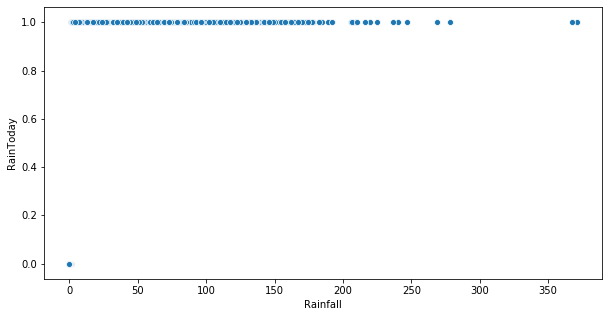

In [26]:
#scatter plot of'RainToday' and 'Rainfall'
plt.figure(figsize=(10,5))
sns.scatterplot(weather['Rainfall'],weather['RainToday'])
plt.show()

The scatter plot indicates strongly that if there was any precipitation greater than 1mm in the 24 hours up to 9am today, then there will be rainfall today. We will therefore drop 'RainToday' from our model.

So far, we have decided to drop 'MinTemp', 'MaxTemp', 'Temp9am', 'Evaporation', 'RainToday','WindSpeed9am' 'WindSpeed3pm', 'Humidity9am' and 'Pressure9am' from our model. 

In [27]:
#dropping listed features
to_drop = ['MinTemp', 'MaxTemp', 'Temp9am', 'Evaporation', 'RainToday','WindSpeed9am',
           'WindSpeed3pm','Humidity9am','Pressure9am']
for col in to_drop:
    features.remove(col)
#check
features

['Date',
 'Location',
 'Rainfall',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'Humidity3pm',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp3pm']

We noted above that we will deal with 'Sunshine', 'Cloud9am', 'Cloud3pm'. These feature have nearly half their values missing. It would be easier to drop these features from our model. However, is it possible to capture their information in another way? Would grouping the weather data by seasons utilising the 'Date' column be useful?

In [28]:
import datetime
weather['Year'] = pd.DatetimeIndex(weather['Date']).year
weather['Season'] = pd.DatetimeIndex(weather['Date']).month
weather['Season'].replace({1: 'Summer', 2:'Summer', 3:'Spring', 4:'Spring', 5:'Spring', 6:'Winter',
                          7:'Winter', 8:'Winter', 9:'Autumn', 10:'Autumn', 11:'Autumn', 12:'Summer'}, inplace=True)
#check
weather['Season'].unique()

array(['Summer', 'Spring', 'Winter', 'Autumn'], dtype=object)

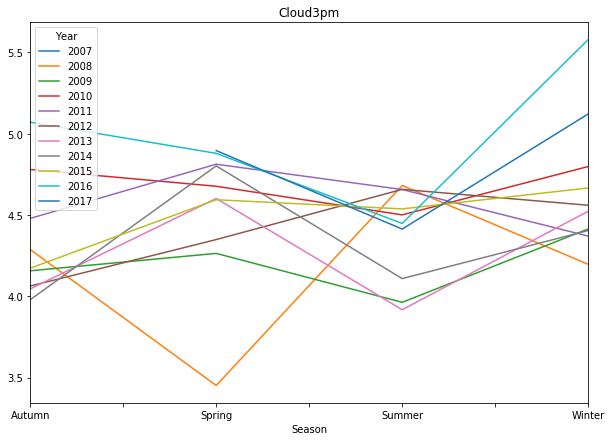

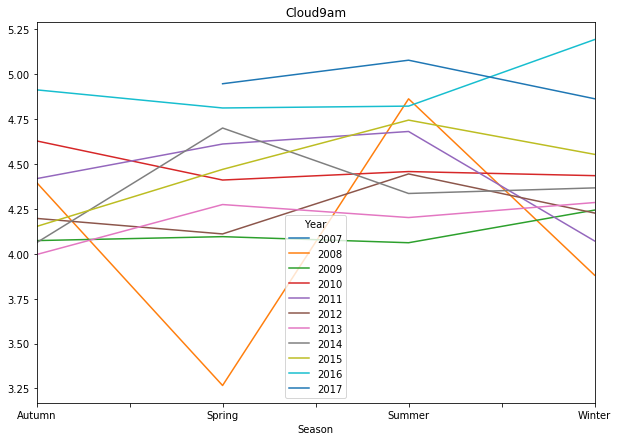

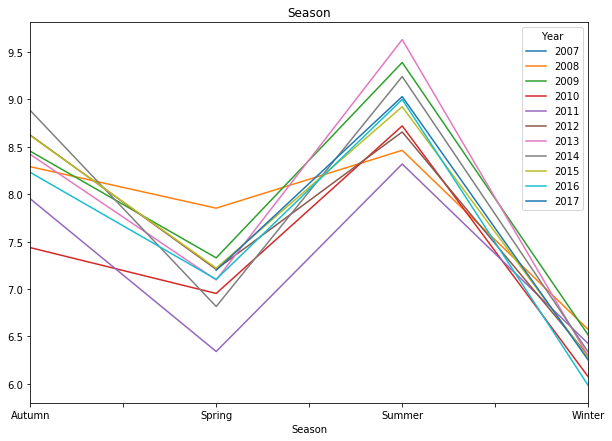

In [29]:
#graphs
weather.pivot_table('Cloud3pm', index='Season', columns='Year', aggfunc='mean').plot(figsize=(10,7), title = 'Cloud3pm')
weather.pivot_table('Cloud9am', index='Season', columns='Year', aggfunc='mean').plot(figsize=(10,7), title = 'Cloud9am')
weather.pivot_table('Sunshine', index='Season', columns='Year', aggfunc='mean').plot(figsize=(10,7), title = 'Season')
plt.show()

'Sunshine' shows a strong seasonal pattern, and 'Cloud3pm' and 'Cloud9am'  do not.  We also know that 'Sunshine' has strong correlations with the cloud variables. We will therefore drop the cloud variables. We can also drop 'Sunshine' as the newly created 'Season' variable will capture some of the information of the 'Sunshine' variable and we no longer have to worry about the chunk of missing values in 'Sunshine'. We will also drop 'Date' and 'Location' as we have no need for those variables. We will add 'Season'.

In [30]:
#dropping listed features
to_drop2 = ['Sunshine','Cloud9am','Cloud3pm', 'Date','Location']
for col in to_drop2:
    features.remove(col)
features.append('Season')
#check
features

['Rainfall',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'Humidity3pm',
 'Pressure3pm',
 'Temp3pm',
 'Season']

Let's check the missing values in the features we have not dropped so far.

In [31]:
weather[features].isnull().sum().sort_values(ascending=False)

Pressure3pm      13769
WindDir9am        9660
WindGustDir       9163
WindGustSpeed     9105
WindDir3pm        3670
Humidity3pm       3501
Temp3pm           2624
Season               0
Rainfall             0
dtype: int64

How many entries will we lose if we drop the rows with missing data?

In [32]:
copy_weather = weather[features].copy()
before = copy_weather.shape[0]
copy_weather = copy_weather.dropna()
after = copy_weather.shape[0]
print('The number of rows dropped will be {} which is {:.2f} % of the remaining dataset.'.format(before - after, ((before-after)/before)*100))

The number of rows dropped will be 27533 which is 19.56 % of the remaining dataset.


This is a considerable portion of the dataset. An exploration of the dataset shows that the missing values for each feature tends to come in orderly chuncks, that is to say, they are missing for consecutive days at a time. This indicates that certain variables were not recorded for particular locations at different periods of time. As a result, we cannot take any kind of average from data points on either side of the missing values without compromising the information in the dataset in a significant way.

Therefore, we will drop the rows with the remaining missing values in the features we have selected so far.

In [33]:
weather = weather.dropna(how='any', subset=features)
weather[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113254 entries, 0 to 142192
Data columns (total 9 columns):
Rainfall         113254 non-null float64
WindGustDir      113254 non-null object
WindGustSpeed    113254 non-null float64
WindDir9am       113254 non-null object
WindDir3pm       113254 non-null object
Humidity3pm      113254 non-null float64
Pressure3pm      113254 non-null float64
Temp3pm          113254 non-null float64
Season           113254 non-null object
dtypes: float64(5), object(4)
memory usage: 8.6+ MB


In [34]:
weather[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113254 entries, 0 to 142192
Data columns (total 9 columns):
Rainfall         113254 non-null float64
WindGustDir      113254 non-null object
WindGustSpeed    113254 non-null float64
WindDir9am       113254 non-null object
WindDir3pm       113254 non-null object
Humidity3pm      113254 non-null float64
Pressure3pm      113254 non-null float64
Temp3pm          113254 non-null float64
Season           113254 non-null object
dtypes: float64(5), object(4)
memory usage: 8.6+ MB


We have three categorical features relating to wind - 'WindDir9am','WindDir3pm','WindGustDir' - plus a categorical feature which we created called 'Season'. As the Logistic Regression model cannot handle categorical values, we will have to transform them into numerical feat We will one-hot encode 'Season' which means that we will have 4 features - one for each season - which takes 1 if the entry is that season and 0 otherwise. Once that is done, we will add the dummy features to our list of features and remove 'Season' from it.

In [35]:
#create dummy variables for 'Season'
dummies_season = pd.get_dummies(weather['Season'], prefix = 'Season')
weather = pd.concat([weather, dummies_season], axis=1)
features.extend(dummies_season.columns.tolist())
features.remove('Season')
#check
weather[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113254 entries, 0 to 142192
Data columns (total 12 columns):
Rainfall         113254 non-null float64
WindGustDir      113254 non-null object
WindGustSpeed    113254 non-null float64
WindDir9am       113254 non-null object
WindDir3pm       113254 non-null object
Humidity3pm      113254 non-null float64
Pressure3pm      113254 non-null float64
Temp3pm          113254 non-null float64
Season_Autumn    113254 non-null uint8
Season_Spring    113254 non-null uint8
Season_Summer    113254 non-null uint8
Season_Winter    113254 non-null uint8
dtypes: float64(5), object(3), uint8(4)
memory usage: 8.2+ MB


We have the wind direction variables left to deal with.

In [36]:
#unique values in 'WindGustDir', 'WindDir9am', WindDir3pm'
windgust_unique = weather['WindGustDir'].unique().tolist()
winddir9am_unique = weather['WindDir9am'].unique().tolist()
winddir3pm_unique = weather['WindDir3pm'].unique().tolist()
print('{} unique values in "WindGustDir": {}'.format(len(windgust_unique), windgust_unique))
print('{} unique values in "WindDir9am": {}'.format(len(winddir9am_unique), winddir9am_unique))
print('{} unique values in "WindDir3pm": {}'.format(len(winddir3pm_unique), winddir3pm_unique))

16 unique values in "WindGustDir": ['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE', 'S', 'NW', 'SE', 'ESE', 'E', 'SSW']
16 unique values in "WindDir9am": ['W', 'NNW', 'SE', 'ENE', 'SW', 'SSE', 'S', 'NE', 'SSW', 'N', 'WSW', 'ESE', 'E', 'NW', 'WNW', 'NNE']
16 unique values in "WindDir3pm": ['WNW', 'WSW', 'E', 'NW', 'W', 'SSE', 'ESE', 'ENE', 'NNW', 'SSW', 'SW', 'SE', 'N', 'S', 'NNE', 'NE']


There are 16 unique values for each of the wind direction features.  

If we one-hot encode the wind direction variables, we will end up with 48 dummy features. Instead, we will note that wind direction can be represented in degrees (of a circle). After we convert the wind direction to degrees, we will then use a technique to engineer cyclical variables which will represent their cyclical nature properly. Please see this [link](http://http://blog.davidkaleko.com/feature-engineering-cyclical-features.html) which explains the method for transforming cyclical variables. 

In [37]:
#mapping wind direction labels to degrees 
dict_dir = {'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5, 'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5, 'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5}
for col in ['WindDir9am', 'WindDir3pm', 'WindGustDir']:
    weather[col].replace(dict_dir, inplace=True)
#check
weather[['WindDir9am', 'WindDir3pm','WindGustDir']].head()

,WindDir9am,WindDir3pm,WindGustDir
0,270.0,292.5,270.0
1,337.5,247.5,292.5
2,270.0,247.5,247.5
3,135.0,90.0,45.0
4,67.5,315.0,270.0


In [38]:
weather[['WindDir9am', 'WindDir3pm','WindGustDir']].head()

,WindDir9am,WindDir3pm,WindGustDir
0,270.0,292.5,270.0
1,337.5,247.5,292.5
2,270.0,247.5,247.5
3,135.0,90.0,45.0
4,67.5,315.0,270.0


In [39]:
#converting wind direction in degrees to values on unit circle, adding to list of features, removing original feature
for col in ['WindDir9am', 'WindDir3pm', 'WindGustDir']:
    weather[col + '_sin'] = np.sin(weather[col]*(2*np.pi/360))
    weather[col + '_cos'] = np.cos(weather[col]*(2*np.pi/360))
    features.append(col + '_sin')
    features.append(col + '_cos')
    features.remove(col)

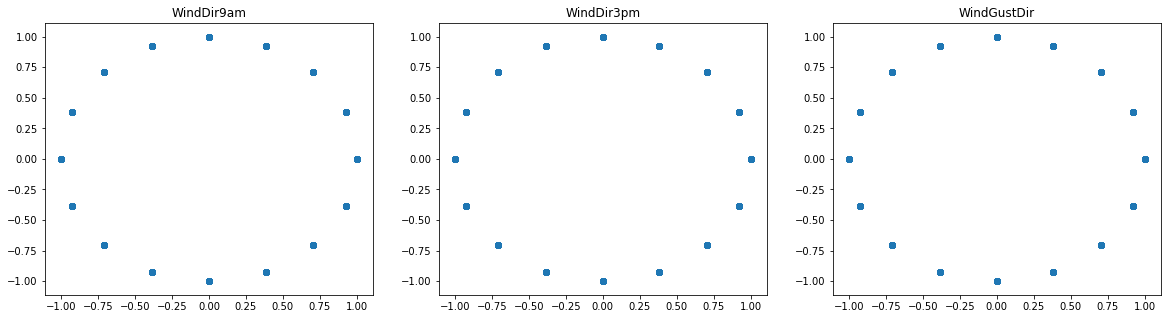

In [40]:
#checking
fig, ax = plt.subplots(1,3,figsize = (20,5))
i = 0
for col in ['WindDir9am', 'WindDir3pm', 'WindGustDir']:
    ax[i].scatter(weather[col + '_sin'], weather[col + '_cos'])
    ax[i].set_title(col)
    i+=1
plt.show()

The circular nature of the wind variables have been captured by this feature transformation.

We can now see if there is any linear relationship between the engineered wind variables such that we can drop one or two of them.

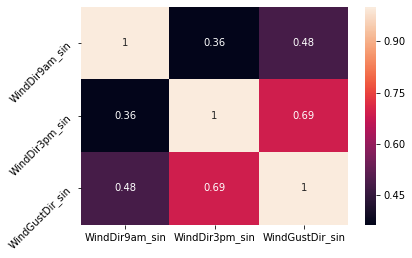

In [41]:
wind_sin_corr = weather[['WindDir9am_sin', 'WindDir3pm_sin','WindGustDir_sin']].corr()
sns.heatmap(wind_sin_corr, annot=True)
plt.yticks(rotation = 45)
#heatmap cuts off top and bottom so following code is a fix
bottom, top = plt.ylim() 
bottom += 0.5 
top -= 0.5 
plt.ylim(bottom, top)
plt.show()

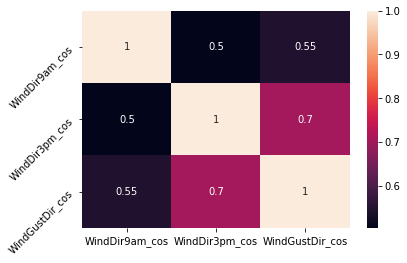

In [42]:
wind_sin_corr = weather[['WindDir9am_cos', 'WindDir3pm_cos','WindGustDir_cos']].corr()
sns.heatmap(wind_sin_corr, annot=True)
#heatmap cuts off top and bottom so following code is a fix
bottom, top = plt.ylim() 
bottom += 0.5 
top -= 0.5 
plt.ylim(bottom, top)
plt.yticks(rotation = 45)
plt.show()

The above correlation matrices show that 'WindDir3pm' and 'WindGustDir' are strongly correlated. We will drop 'WindGustDir'.

In [43]:
features.remove('WindGustDir_sin')
features.remove('WindGustDir_cos')
features

['Rainfall',
 'WindGustSpeed',
 'Humidity3pm',
 'Pressure3pm',
 'Temp3pm',
 'Season_Autumn',
 'Season_Spring',
 'Season_Summer',
 'Season_Winter',
 'WindDir9am_sin',
 'WindDir9am_cos',
 'WindDir3pm_sin',
 'WindDir3pm_cos']

In [44]:
print('The selected features for the Logistic Regression model are: \n {}'.format(features))

The selected features for the Logistic Regression model are: 
 ['Rainfall', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'Temp3pm', 'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'WindDir9am_sin', 'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos']


[Back to contents](#back)

# <div id='mt'></div> Model training

**<div id='split'></div>Split the data set into training and testing datasets**

In [45]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(weather[features], weather['RainTomorrow'], test_size = 0.2, random_state = 0)

**<div id='scale'></div>Scale features**

In [46]:
columns_to_scale = ['Rainfall', 'WindGustSpeed','Humidity3pm','Pressure3pm','Temp3pm']
train_X[columns_to_scale].describe()

,Rainfall,WindGustSpeed,Humidity3pm,Pressure3pm,Temp3pm
count,90603.000000,90603.000000,90603.000000,90603.000000,90603.00000
mean,2.401712,40.809410,50.673068,1015.048887,22.12034
std,8.671055,13.326173,20.748700,6.961599,6.83336
min,0.000000,7.000000,0.000000,977.100000,2.30000
25%,0.000000,31.000000,36.000000,1010.300000,16.90000
50%,0.000000,39.000000,51.000000,1015.000000,21.60000
75%,0.800000,48.000000,65.000000,1019.700000,26.90000
max,367.600000,135.000000,100.000000,1039.600000,46.70000


The features above have different ranges. We will scale them so that they are in the range [0,1]. 

In [47]:
from sklearn.preprocessing import minmax_scale

for col in columns_to_scale:
    train_X[col + "_scaled"] = minmax_scale(train_X[col])
    test_X[col + "_scaled"] = minmax_scale(test_X[col])
    weather[col + "_scaled"] = minmax_scale(weather[col])
    features.append(col + '_scaled')
    features.remove(col)
features

['Season_Autumn',
 'Season_Spring',
 'Season_Summer',
 'Season_Winter',
 'WindDir9am_sin',
 'WindDir9am_cos',
 'WindDir3pm_sin',
 'WindDir3pm_cos',
 'Rainfall_scaled',
 'WindGustSpeed_scaled',
 'Humidity3pm_scaled',
 'Pressure3pm_scaled',
 'Temp3pm_scaled']

In [48]:
train_X.columns

Index(['Rainfall', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'Temp3pm',
       'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'WindDir9am_sin', 'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos',
       'Rainfall_scaled', 'WindGustSpeed_scaled', 'Humidity3pm_scaled',
       'Pressure3pm_scaled', 'Temp3pm_scaled'],
      dtype='object')

In [49]:
test_X.columns

Index(['Rainfall', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'Temp3pm',
       'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'WindDir9am_sin', 'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos',
       'Rainfall_scaled', 'WindGustSpeed_scaled', 'Humidity3pm_scaled',
       'Pressure3pm_scaled', 'Temp3pm_scaled'],
      dtype='object')

**<div id= 'train'></div>Train the model and predict**

We will use sklearn's Logistic Regression Classifier to train and predict the model.

In [50]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(max_iter=1000, solver = 'lbfgs' )
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)

**<div id='eval'></div>Evaluate**

In [51]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.metrics import accuracy_score

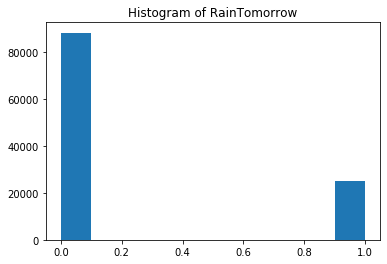

In [52]:
plt.figure()
plt.hist(weather['RainTomorrow'])
plt.title('Histogram of RainTomorrow')
plt.show()

The histogram above shows that the **RainTomorrow** data is highly skewed. There are nearly 4 times more occurences of no rain than rain. Therefore, to evaluate our data, we will need to calculate precision and recall, as the  accuracy score will not give a good picture of the model's performance.

The function below will calculate accuracy score, null accuracy, precision, recall, specificity, and the F_score of the model using a confusion matrix.

In [53]:
#evaluation function
def evaluation(test_y, predictions):
    
    #accuracy score
    accuracy = accuracy_score(test_y, predictions)
    print("The classification accuracy is {:.2f} %." .format(accuracy*100))
    
  
    y_test_mean = test_y.mean()
    #null accuracy
    null_accuracy = max(y_test_mean, 1-y_test_mean)
    print('The null accuracy is {:.2f} %.'.format(null_accuracy*100))
    
    #confusion matrix
    skplt.metrics.plot_confusion_matrix(test_y, predictions)
    
    conf_matrix = confusion_matrix(test_y, predictions)
    #heatmap cuts off top and bottom so following code is a fix
    bottom, top = plt.ylim() 
    bottom += 0.5 
    top -= 0.5 
    plt.ylim(bottom, top)
    
    
    TN = conf_matrix[0,0] #true negatives
    FP = conf_matrix[0,1] #false positives
    FN = conf_matrix[1,0] #false negatives
    TP = conf_matrix[1,1] #true positives
    
    #precision
    precision = TP/(TP+FP)*100
    print('The precision is {:.2f} %.'.format(precision))
    #sensitivity/ recall
    recall = TP/(FN+TP)*100
    print('The sensitivity/recall is {:.2f} %.'.format(recall))
    #specificity
    specificity = TN/(FP+TN)*100
    print('The specificity is {:.2f} %.'.format(specificity))
    #F_score
    F_score = (2*precision*recall)/(precision + recall)
    print('The F score is {:.2f} %.'.format(F_score))
    
    return None

The classification accuracy is 84.66 %.
The null accuracy is 77.91 %.
The precision is 71.35 %.
The sensitivity/recall is 51.07 %.
The specificity is 94.19 %.
The F score is 59.53 %.


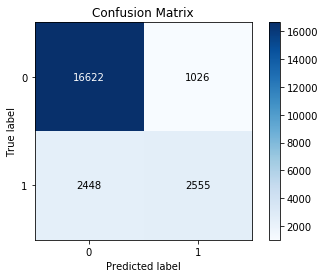

In [54]:
evaluation(test_y, predictions)

Evaluation scores:

* The model predicts the correct label 84.68% of the time. This is not much higher than the null accuracy score of 77.91% which is the score a model will get if it predicted the dominant class all the time.
* Both precision and recall are not high. Of all the true instances of rain, the model correctly predicts rain only 53.01% of the time. This is not good for a rain prediction model as that is its entire purpose. To increase recall, we can lower the prediction threshold from 0.5 (the default in the sklearn model). This will however lead to lower precision.

Is the model suffering from high bias or high variance?


### Diagnostics

In [55]:
#splitting data into train, validation, and test set in proportions of 60%, 20%, and 20% respectively
X_set, X_test, y_set, y_test = train_test_split(weather[features], weather['RainTomorrow'], test_size = 0.2, random_state = 0)
X_train, X_cv, y_train, y_cv = train_test_split(X_set, y_set, test_size = 0.25, random_state = 0)

In [56]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import normalize

In [57]:
#create polynomial variables of specified degree and scale them

def PolyAndScale(X, degree):
    
    #initialise polynomial transformer 
    poly = PolynomialFeatures(degree = degree, include_bias = True)
    #fit and return polynomial features
    X_poly = poly.fit_transform(X)
    #normalise X_poly
    X_poly = normalize(X_poly, axis=0)
    
    return X_poly
    

In [58]:
from sklearn.linear_model import LogisticRegression

lr_poly = LogisticRegression(max_iter=2000, fit_intercept=False, solver='lbfgs')

In [59]:
def PredictAndError(X, y):
    
    #predict and  calculate error
    prediction = lr_poly.predict(X)
    #misclassification error
    error = 1 - accuracy_score(y_true = y, y_pred = prediction)
    
    return error
    

In [60]:
def LearningCurvesPoly(X_train, X_cv, y_train, y_cv):

    poly_degrees = [1,2,3,4,]

    train_costs = []
    cv_costs = []

    for p in poly_degrees:
        X_tr = PolyAndScale(X_train, degree=p)
        lr_poly.fit(X_tr, y_train)
        train_error = PredictAndError(X_tr, y_train)
        train_costs.append(train_error)
        X_crossval = PolyAndScale(X_cv, degree=p)
        cv_error = PredictAndError(X_crossval, y_cv)
        cv_costs.append(cv_error)
        
    
    #plot learning curves
    plt.figure(figsize=(10,10))
    plt.plot(train_costs, label = 'Train')
    plt.plot(cv_costs, label = 'CV')
    plt.legend(loc="upper right")
    plt.xlabel('Polynomial degree')
    plt.xticks(ticks = [0,1,2,3], labels = [1,2,3,4])
    plt.ylabel('Misclassification Error')
    plt.title('Learning Curves')
    plt.show()
    
    return None
    

We will plot the errors of both the training and cross-validation set for polynomial degrees from 1 to 4 to see if the model is suffering from either high bias or high variance.

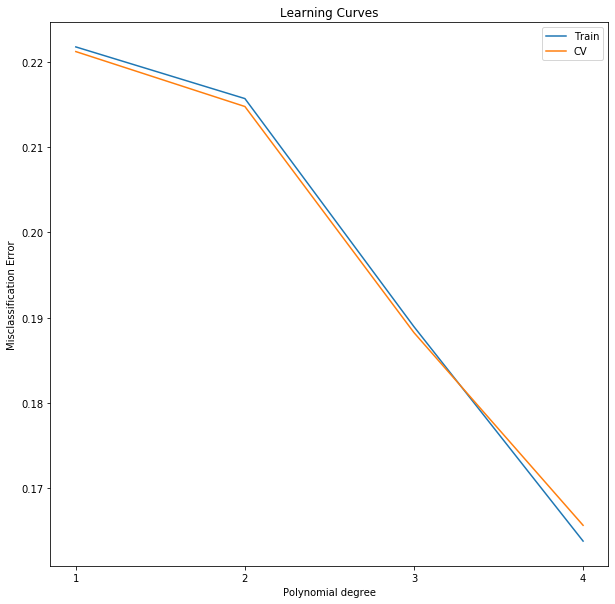

In [61]:
LearningCurvesPoly(X_train, X_cv, y_train, y_cv)

Both the training error and the cross-validation error decrease with increasing degrees of the polynomial function. As the model increases in complexity, the misclassification errors of both sets fall. The model is underfitting and will benefit from additional features and/ or polynomial features. 

[Back to contents](#back)